In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Download and convert .data file and save to csv

In [7]:
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
#                 'Acceleration', 'Model Year', 'Origin']

# raw_df = pd.read_csv(url, names=column_names,
#                     na_values='?', comment ='\t',
#                     sep=' ', skipinitialspace = True)

# raw_df.to_csv('auto-mg.csv', index=False)

# Load and Inspect the data

In [8]:
df = pd.read_csv('auto-mg.csv')

In [9]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [10]:
df.var()

MPG                 61.089611
Cylinders            2.893415
Displacement     10872.199152
Horsepower        1481.569393
Weight          717140.990526
Acceleration         7.604848
Model Year          13.672443
Origin               0.643292
dtype: float64

In [11]:
# Checking for NaN values
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [12]:
# Identifying the column with the highest correlation to the column containing NaN values
df.corr()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
MPG,1.000000,-0.775396,-0.804203,-0.778427,-0.831741,0.420289,0.579267,0.563450
Cylinders,-0.775396,1.000000,0.950721,0.842983,0.896017,-0.505419,-0.348746,-0.562543
Displacement,-0.804203,0.950721,1.000000,0.897257,0.932824,-0.543684,-0.370164,-0.609409
Horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
Weight,-0.831741,0.896017,0.932824,0.864538,1.000000,-0.417457,-0.306564,-0.581024
Acceleration,0.420289,-0.505419,-0.543684,-0.689196,-0.417457,1.000000,0.288137,0.205873
Model Year,0.579267,-0.348746,-0.370164,-0.416361,-0.306564,0.288137,1.000000,0.180662
Origin,0.563450,-0.562543,-0.609409,-0.455171,-0.581024,0.205873,0.180662,1.000000


# Mapping Values to NaN

In [13]:
# After inpecting lets fill the NaNs based on the groupby average of a highly correlated column
# Displacement has the highest correlation but too much variation for average mapping lets go with cylinders
# Creating a boolean mask to locate NaN values
hp_mask = df['Horsepower'].isnull()

# Groupby a highly correlated column and averaging the target column(Horsepower) values
cylinders = dict(df.groupby('Cylinders')['Horsepower'].mean())

# Mapping these highly correlated averages to the target column
df.loc[hp_mask, 'Horsepower'] = df.loc[hp_mask, 'Cylinders'].map(cylinders)
df[df['Horsepower'].isnull()]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin


In [14]:
# One-Hot encoding the Origin column
df['Origin'] = df['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})
df = pd.get_dummies(df, prefix='', prefix_sep='')
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


# Splitting the data

In [15]:
train_data = df.sample(frac=0.8, random_state=32)
test_data = df.drop(train_data.index)

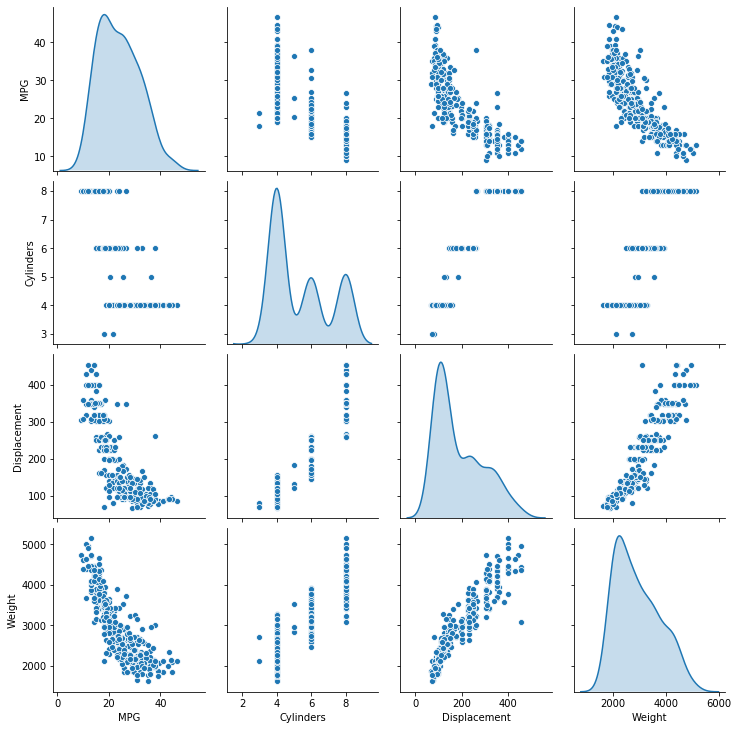

In [16]:
# As described by df.corr() all rows are a function of each other
sns.pairplot(train_data[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.show()

In [17]:
# Each feature covers a very different range:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,318.0,23.974214,7.894387,9.0,18.00,23.35,29.875,46.6
Cylinders,318.0,5.393082,1.658422,3.0,4.00,4.00,6.000,8.0
Displacement,318.0,189.646226,103.027981,68.0,98.00,142.50,258.000,455.0
Horsepower,318.0,102.528697,38.330227,46.0,75.00,90.00,115.000,230.0
Weight,318.0,2928.176101,827.842691,1613.0,2206.25,2740.00,3523.750,5140.0
Acceleration,318.0,15.706289,2.770193,8.0,14.00,15.50,17.300,24.6
Model Year,318.0,76.125786,3.742909,70.0,73.00,76.00,79.000,82.0
Europe,318.0,0.176101,0.381506,0.0,0.00,0.00,0.000,1.0
Japan,318.0,0.201258,0.401572,0.0,0.00,0.00,0.000,1.0
USA,318.0,0.622642,0.485490,0.0,0.00,1.00,1.000,1.0


In [18]:
# Splitting for training
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Single-variable Linear Regression

In [19]:
# Normalize variance of the dataset
# Convert to numpy array 
horsepower = np.array(train_features['Horsepower'])
# Set normalizer for single feature normalization 
hp_normalizer = preprocessing.Normalization(input_shape=[1,])
# Fit the normalizer to the horsepower array
hp_normalizer.adapt(horsepower)

In [20]:
# Simple Sequential Model
horsepower_model = tf.keras.Sequential([
    hp_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
# Configure Training Procedure
horsepower_model.compile(optimizer= tf.optimizers.Adam(learning_rate=0.1),
                        loss='mean_absolute_error')

In [22]:
# Execute Training
history = horsepower_model.fit(train_features['Horsepower'],
                     train_labels,
                     epochs=100,
                     verbose=1,
                     validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 1s 28ms/step - loss: 23.9539 - val_loss: 22.9728
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 23.7411 - val_loss: 22.1705
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 21.8665 - val_loss: 21.3925
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 21.4477 - val_loss: 20.5984
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 20.0503 - val_loss: 19.8222
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 19.2165 - val_loss: 19.0331
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 18.6720 - val_loss: 18.2460
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 18.9771 - val_loss: 17.4435
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 17.0838 - val_loss: 16.6602
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 16.6666 - val_loss: 15.8611
Epoch 11

8/8 [==============================] - 0s 6ms/step - loss: 3.9501 - val_loss: 4.1096
Epoch 85/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8467 - val_loss: 4.1293
Epoch 86/100
8/8 [==============================] - 0s 6ms/step - loss: 3.9872 - val_loss: 4.1240
Epoch 87/100
8/8 [==============================] - 0s 6ms/step - loss: 3.9050 - val_loss: 4.0947
Epoch 88/100
8/8 [==============================] - 0s 5ms/step - loss: 3.9673 - val_loss: 4.1109
Epoch 89/100
8/8 [==============================] - 0s 6ms/step - loss: 3.5408 - val_loss: 4.1153
Epoch 90/100
8/8 [==============================] - 0s 6ms/step - loss: 4.2063 - val_loss: 4.1072
Epoch 91/100
8/8 [==============================] - 0s 6ms/step - loss: 4.0274 - val_loss: 4.1024
Epoch 92/100
8/8 [==============================] - 0s 6ms/step - loss: 3.7027 - val_loss: 4.1205
Epoch 93/100
8/8 [==============================] - 0s 6ms/step - loss: 4.1356 - val_loss: 4.1110
Epoch 94/100
8/8 [===============

In [23]:
# Saving model fit history to dictionary
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'val_loss'])

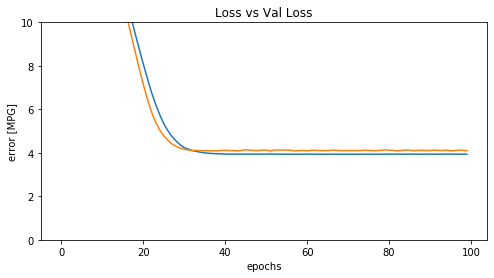

In [24]:
# Plot loss vs val_loss

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(8,4))
plt.plot(loss, label='loss')
plt.plot( val_loss, label='val_loss')
plt.ylim([0, 10])
plt.title('Loss vs Val Loss')
plt.xlabel('epochs')
plt.ylabel('error [MPG]')
plt.show()

In [25]:
# Model test loss
test_history = horsepower_model.evaluate(test_features['Horsepower'],
                                        test_labels, verbose=1)

3/3 [==============================] - 0s 3ms/step - loss: 3.3476


In [26]:
# Look at the model's predictions as a function of the input (max hp is 230)
x = tf.linspace(0.0, 240, 241)
y = horsepower_model.predict(x)

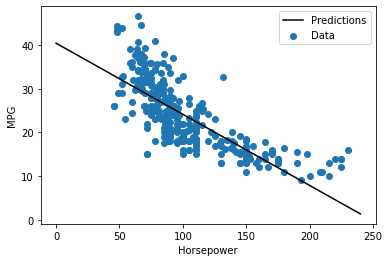

In [27]:
# Plit the models predictions of x against the actual data
plt.scatter(train_features['Horsepower'], train_labels, label='Data')
plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.legend()
plt.show()

# Multi-variable Linear Regression

In [28]:
# Normalize the train dataset
normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[   5.393  189.646  102.529 2928.176   15.706   76.126    0.176    0.201
    0.623]


In [29]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.  151.   90. 2735.   18.   82.    0.    0.    1.]]

Normalized: [[-0.84 -0.38 -0.33 -0.23  0.83  1.57 -0.46 -0.5   0.78]]


In [30]:
# Adding the train_features normalizer
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [31]:
# weight matrices
model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.215],
       [ 0.376],
       [-0.281],
       [ 0.546],
       [ 0.594],
       [-0.711],
       [ 0.358],
       [-0.534],
       [ 0.453]], dtype=float32)>

In [32]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [33]:
history = model.fit(train_features, 
                    train_labels,
                    validation_split=0.2,
                    verbose=1,
                    epochs=100
                   )

Epoch 1/100
8/8 [==============================] - 1s 19ms/step - loss: 23.9635 - val_loss: 22.9469
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.9076 - val_loss: 22.1714
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 22.3958 - val_loss: 21.3988
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 21.3225 - val_loss: 20.6415
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 20.7211 - val_loss: 19.8733
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 19.8885 - val_loss: 19.0928
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 18.5210 - val_loss: 18.3230
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 17.7897 - val_loss: 17.5578
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 17.2209 - val_loss: 16.8014
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 16.4426 - val_loss: 16.0376
Epoch 11

8/8 [==============================] - 0s 7ms/step - loss: 2.6690 - val_loss: 2.3164
Epoch 85/100
8/8 [==============================] - 0s 5ms/step - loss: 2.6544 - val_loss: 2.3338
Epoch 86/100
8/8 [==============================] - 0s 7ms/step - loss: 2.3474 - val_loss: 2.3528
Epoch 87/100
8/8 [==============================] - 0s 5ms/step - loss: 2.3645 - val_loss: 2.3683
Epoch 88/100
8/8 [==============================] - 0s 5ms/step - loss: 2.4195 - val_loss: 2.3737
Epoch 89/100
8/8 [==============================] - 0s 41ms/step - loss: 2.4694 - val_loss: 2.3412
Epoch 90/100
8/8 [==============================] - 0s 7ms/step - loss: 2.5852 - val_loss: 2.3416
Epoch 91/100
8/8 [==============================] - 0s 7ms/step - loss: 2.4980 - val_loss: 2.3979
Epoch 92/100
8/8 [==============================] - 0s 7ms/step - loss: 2.5301 - val_loss: 2.3720
Epoch 93/100
8/8 [==============================] - 0s 7ms/step - loss: 2.4798 - val_loss: 2.3224
Epoch 94/100
8/8 [==============

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'val_loss'])

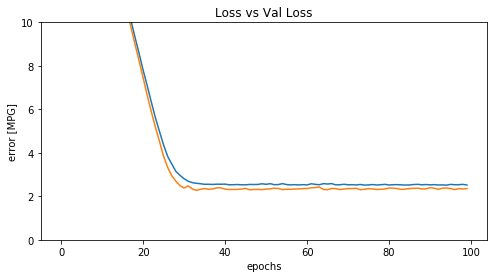

In [35]:
# Plot loss vs val_loss starting at 100 

loss = history_dict['loss']
val_loss = history_dict['val_loss']


plt.figure(figsize=(8,4))
plt.plot(loss, label='loss')
plt.plot( val_loss, label='val_loss')
plt.ylim([0, 10])
plt.title('Loss vs Val Loss')
plt.xlabel('epochs')
plt.ylabel('error [MPG]')
plt.show()